# **Language models for feature generation**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sekhansen/text_algorithms_econ/blob/main/notebooks/5_llm_features.ipynb)

This notebook will show how to use a modern language model to create numeric features from text data and perform a classification task. Although the notebook will demonstrate one particular language model (i.e. BERT) the same pipeline and code can be used with multiple other language models.

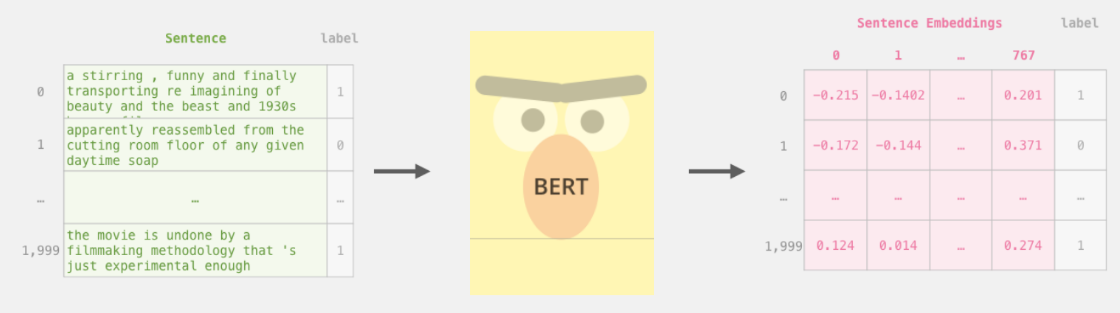

Some useful external resources:

- **Original BERT paper**. Devlin et al. (2019). *BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding*. [Available online here](https://arxiv.org/pdf/1810.04805.pdf)
- **Book chapter**. Jurafsky & Martin (2021). *Transfer Learning with Pre-trained Language Models and Contextual Embeddings*. [Available online here.](https://web.stanford.edu/~jurafsky/slp3/11.pdf)
- **Book chapter**. Jurafsky & Martin (2021). *Deep Learning Architectures for Sequence Processing*. [Available online.](https://web.stanford.edu/~jurafsky/slp3/9.pdf)
- **Blog post**. Alammar (2018). [Available online here](https://jalammar.github.io/illustrated-bert/)
- **Blog post**. Alammar (2019). [Available online here](https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)
- **Applied tutorial**. AssemblyAI (2022). [Available online here.](https://www.youtube.com/watch?v=QEaBAZQCtwE)

# 0. Setup

In [ ]:
# Instructions for Colab: 
# 1. First CHANGE RUNTIME TYPE to GPU 
# 2. Run install commands
# 3. You might need to RESTART RUNTIME
# 4. Run the rest of the cells below

In [2]:
%%capture

# install required libraries
!pip3 install transformers                  # HuggingFace library for interacting with BERT (and multiple other models)
!pip3 install datasets                      # HuggingFace library to process dataframes
!pip3 install sentence-transformers         # library to use Sentence Similarity BERT
!pip3 install bertviz                       # visualize BERT's attention weigths
!pip3 install annoy                         # Spotify's library for finding nearest neighbours                     
!pip3 install ipywidgets

In [ ]:
# (COLAB) you might need to restart RUNTIME after installing packages!

In [ ]:
# import libraries
import gdown
import pandas as pd
import numpy as np
import gdown
import random
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch

from transformers import AutoModel, BertModel, AutoTokenizer, BertForSequenceClassification, pipeline, TrainingArguments, Trainer, utils
from transformers.pipelines.base import KeyDataset
from datasets import load_dataset, load_metric, Dataset, DatasetDict

from gensim.models import Word2Vec
import gensim.downloader as api

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from google.colab import output
output.enable_custom_widget_manager()

# test GPU
print(f"GPU: {torch.cuda.is_available()}")

GPU: True


In [ ]:
# define dictionary with paths to data in Google Drive
urls_dict = {"10k_sent_2019":        ("https://drive.google.com/uc?id=17PQbZ6EotMxyhpt2Laqqh9z-EKUbwDhX", "parquet"),
             "covariates_2019":      ("https://drive.google.com/uc?id=1ELRq69FOiFvNpSvXOijGeGKZB5DiNXt4", "csv"),
            }

In [ ]:
# download all files
for file_name, attributes in urls_dict.items():
    url = attributes[0]
    extension = attributes[1]
    gdown.download(url, f"./{file_name}.{extension}", quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=17PQbZ6EotMxyhpt2Laqqh9z-EKUbwDhX
To: /content/10k_sent_2019.parquet
100%|██████████| 162M/162M [00:04<00:00, 39.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ELRq69FOiFvNpSvXOijGeGKZB5DiNXt4
To: /content/covariates_2019.csv
100%|██████████| 428k/428k [00:00<00:00, 126MB/s]


# 1. Load and prepare the data

This tutorial uses text data from the **10-K reports** filed by publicly-traded firms in the U.S. in 2019. 10-K reports are a very rich source of data since firms include information regarding their organizational structure, financial performance and risk factors. We will use a version of the data where the risk factors section of each report has been splitted into sentences and each sentence has been assigned an ID that combines the firm identifier (i.e. **CIK**) and a sentence number. The raw data we use has a total of 1,744,131 sentences for 4,033 firms.

More on the 10-K reports [here](https://www.investor.gov/introduction-investing/getting-started/researching-investments/how-read-10-k).

In [ ]:
# read data
df = pd.read_parquet("10k_sent_2019.parquet")
df

,sentences,cik,year,sent_no,sent_id
0,You should carefully review the following disc...,1065088,2019,0,1065088_0
1,"Risk Factors That May Affect our Business, Res...",1065088,2019,1,1065088_1
2,Our operating and financial results are subjec...,1065088,2019,2,1065088_2
3,Our operating and financial results have varie...,1065088,2019,3,1065088_3
4,It is difficult for us to forecast the level o...,1065088,2019,4,1065088_4
...,...,...,...,...,...
1744126,,1069533,2019,189,1069533_189
1744127,The Company is generally isolated from commodi...,1069533,2019,190,1069533_190
1744128,,1069533,2019,191,1069533_191
1744129,"With respect to interest rate risk, the Compan...",1069533,2019,192,1069533_192


In [ ]:
# firm-level additional data
covariates = pd.read_csv("covariates_2019.csv")
covariates.head()

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,conm,curcd,act,at,emp,cik,costat,naics,naics2,naics2_name
0,1004,20200531,2019,INDL,C,D,STD,AIR,AAR CORP,USD,1438.700,2079.000,5.400,1750,A,423860,42,Wholesale Trade
1,1050,20191231,2019,INDL,C,D,STD,CECE,CECO ENVIRONMENTAL CORP,USD,179.498,408.637,0.830,3197,A,333413,33,Manufacturing
2,1078,20191231,2019,INDL,C,D,STD,ABT,ABBOTT LABORATORIES,USD,15667.000,67887.000,107.000,1800,A,334510,33,Manufacturing
3,1104,20191231,2019,INDL,C,D,STD,ACU,ACME UNITED CORP,USD,73.146,110.749,0.441,2098,A,332215,33,Manufacturing
4,1117,20191231,2019,INDL,C,D,STD,BKTI,BK TECHNOLOGIES CORP,USD,23.886,37.940,0.111,2186,A,334220,33,Manufacturing


In [ ]:
# we will choose some specific firms of interest using their TIC identifiers
tics = ["AAPL", "GOOGL", "TWTR", "ORCL", "TSLA", "GM", "F", "BAC", 
        "COF", "JPM", "AXP", "HBC2", "TGT", "M", "WMT", "COST", 
        "BNED", "DIS", "FOXA", "ADSK", "CAT", "BA"]

# subset covariates
covariates_focus = covariates.loc[covariates["tic"].isin(tics)]
covariates_focus = covariates_focus.groupby("tic", as_index=False).max()
covariates_focus

,tic,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,conm,curcd,act,at,emp,cik,costat,naics,naics2,naics2_name
0,AAPL,1690,20190930,2019,INDL,C,D,STD,APPLE INC,USD,162819.000,338516.000,137.000,320193,A,334220,33,Manufacturing
1,ADSK,1878,20200131,2019,INDL,C,D,STD,AUTODESK INC,USD,2659.300,6179.300,10.100,769397,A,519130,51,Information
2,AXP,1447,20191231,2019,INDL,C,D,STD,AMERICAN EXPRESS CO,USD,NaN,198321.000,64.500,4962,A,522210,52,Finance and Insurance
3,BA,2285,20191231,2019,INDL,C,D,STD,BOEING CO,USD,102229.000,133625.000,161.100,12927,A,336411,33,Manufacturing
4,BAC,7647,20191231,2019,INDL,C,D,STD,BANK OF AMERICA CORP,USD,NaN,2434079.000,208.131,70858,A,522110,52,Finance and Insurance
5,BNED,23208,20200430,2019,INDL,C,D,STD,BARNES & NOBLE EDUCATION INC,USD,584.919,1156.432,5.500,1634117,A,451211,45,Retail Trade
6,CAT,2817,20191231,2019,INDL,C,D,STD,CATERPILLAR INC,USD,39193.000,78453.000,102.300,18230,A,333120,33,Manufacturing
7,COF,30990,20191231,2019,INDL,C,D,STD,CAPITAL ONE FINANCIAL CORP,USD,NaN,390365.000,51.900,927628,A,522210,52,Finance and Insurance
8,COST,29028,20190831,2019,INDL,C,D,STD,COSTCO WHOLESALE CORP,USD,23485.000,45400.000,254.000,909832,A,452311,45,Retail Trade
9,DIS,3980,20190930,2019,INDL,C,D,STD,DISNEY (WALT) CO,USD,28124.000,193984.000,223.000,1744489,A,515120,51,Information


In [ ]:
# look at their 2 digit NAICS sector code
covariates_focus.groupby("naics2_name").size()

naics2_name
Finance and Insurance    5
Information              6
Manufacturing            6
Retail Trade             5
dtype: int64

In [ ]:
# generate a dictionary mapping from CIK to name
cik2name = {row["cik"]: row["conm"] for i, row in covariates_focus.iterrows()}

# select the 10K reports from the choosen firms only
df = df.loc[df["cik"].isin(covariates_focus["cik"])]
df.reset_index(drop=True, inplace=True)
df

,sentences,cik,year,sent_no,sent_id
0,The following discussion sets forth the materi...,19617,2019,0,19617_0
1,Readers should not consider any descriptions o...,19617,2019,1,19617_1
2,Any of the risk factors discussed below could ...,19617,2019,2,19617_2
3,Regulatory,19617,2019,3,19617_3
4,JPMorgan Chase's businesses are highly regulat...,19617,2019,4,19617_4
...,...,...,...,...,...
7279,"With the completion of the TFCF acquisition, o...",1744489,2019,194,1744489_194
7280,The increased indebtedness could have the effe...,1744489,2019,195,1744489_195
7281,The increased levels of indebtedness could als...,1744489,2019,196,1744489_196
7282,"repurchases and dividends, and other activitie...",1744489,2019,197,1744489_197


In [ ]:
# lets explore a random sentence from our corpus
i = np.random.randint(0, len(df))
print(f"Sentence from: {cik2name[df.loc[i, 'cik']]}\n")
print(df.loc[i, "sentences"])

Sentence from: APPLE INC

The Company is subject to various legal proceedings and claims that have arisen in the ordinary course of business and have not yet been fully resolved, and new claims may arise in the future.


In [ ]:
# merge each sentence with the NAICS2 code and name from its corresponding firm
df = pd.merge(df, covariates_focus[["cik", "naics2", "naics2_name"]], how="left", on="cik")
df

,sentences,cik,year,sent_no,sent_id,naics2,naics2_name
0,The following discussion sets forth the materi...,19617,2019,0,19617_0,52,Finance and Insurance
1,Readers should not consider any descriptions o...,19617,2019,1,19617_1,52,Finance and Insurance
2,Any of the risk factors discussed below could ...,19617,2019,2,19617_2,52,Finance and Insurance
3,Regulatory,19617,2019,3,19617_3,52,Finance and Insurance
4,JPMorgan Chase's businesses are highly regulat...,19617,2019,4,19617_4,52,Finance and Insurance
...,...,...,...,...,...,...,...
7279,"With the completion of the TFCF acquisition, o...",1744489,2019,194,1744489_194,51,Information
7280,The increased indebtedness could have the effe...,1744489,2019,195,1744489_195,51,Information
7281,The increased levels of indebtedness could als...,1744489,2019,196,1744489_196,51,Information
7282,"repurchases and dividends, and other activitie...",1744489,2019,197,1744489_197,51,Information


In [ ]:
# drop empty sentences or sentences with very few words
min_words = 3
df["sentence_len"] = df["sentences"].apply(lambda x: len(x.split()))
df["keep_sent"] = df["sentence_len"].apply(lambda x: x > min_words)
df = df.loc[df["keep_sent"]]
df.reset_index(drop=True, inplace=True)
df

,sentences,cik,year,sent_no,sent_id,naics2,naics2_name,sentence_len,keep_sent
0,The following discussion sets forth the materi...,19617,2019,0,19617_0,52,Finance and Insurance,18,True
1,Readers should not consider any descriptions o...,19617,2019,1,19617_1,52,Finance and Insurance,23,True
2,Any of the risk factors discussed below could ...,19617,2019,2,19617_2,52,Finance and Insurance,53,True
3,JPMorgan Chase's businesses are highly regulat...,19617,2019,4,19617_4,52,Finance and Insurance,25,True
4,JPMorgan Chase is a financial services firm wi...,19617,2019,5,19617_5,52,Finance and Insurance,10,True
...,...,...,...,...,...,...,...,...,...
6793,"With the completion of the TFCF acquisition, o...",1744489,2019,194,1744489_194,51,Information,19,True
6794,The increased indebtedness could have the effe...,1744489,2019,195,1744489_195,51,Information,22,True
6795,The increased levels of indebtedness could als...,1744489,2019,196,1744489_196,51,Information,14,True
6796,"repurchases and dividends, and other activitie...",1744489,2019,197,1744489_197,51,Information,21,True


In [ ]:
# save the dataset
# df.to_parquet("10k_sent_2019_firms.parquet", index=False)

In [ ]:
# # lastly we will load the names of the NAICS2 codes
# df_naics = pd.read_csv("naics2_codes.csv")
# df_naics

# 2. Accessing BERT through HuggingFace

### HuggingFace

We will use use  the ```transformers``` library developed by HuggingFace to access and interact with BERT. This library provides very convenient classes (e.g. ```Tokenizer```, ```Model```, ```Pipeline```) that will help us to easily pass our text through BERT (or any other transformer model we wish). 

> As a starting point, we will use a basic version of the original BERT model in English that is not case sensitive. We access this model with the name ```bert-base-uncased```. You can read more about the model [here](https://huggingface.co/bert-base-uncased).

> Through the [Model Hub](https://huggingface.co/models) you can browse all the available models currently hosted by HuggingFace. Here you will find other types of language models and many more languages (including [multilingual models](https://huggingface.co/bert-base-multilingual-cased) and [models in Spanish](https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased) ). 


### Text tokenization

We will start by using the ```AutoTokenizer``` class to load the tokenizer from ```bert-base-uncased```. BERT´s Tokenizer was trained on English Wikipedia and the Book Corpus and contains a total amount of 30,522 unique tokens.

In [ ]:
# load a tokenizer using the name of the model we want to use
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
# inspect the configuration of the tokenizer
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [ ]:
# explore the vocabulary of the tokenizer by looking at some words
vocab = tokenizer.get_vocab()
print(f"Total number of tokens in vocabulary: {len(vocab)} \n---------")
for _ in range(10):
    word, idx = random.choice(list(vocab.items()))
    print(word, idx)

Total number of tokens in vocabulary: 30522 
---------
reign 5853
lange 21395
poking 21603
##bush 22427
marguerite 15334
720 22857
〉 1638
sumatra 18262
bungalow 27563
musee 18070


Passing a list of sequences to the tokenizer object will apply the following steps to each sequence:

1. Breakdown the sequence into individual tokens that are part of BERT's vocabulary 
2. Transform tokens into their ids
3. Add special tokens
4. Apply truncation and padding (optional)

In [ ]:
# pass all sequences through the tokenizer
encoded_sentences = tokenizer(list(df["sentences"].values),     # list of sequences we want to tokenize
                              truncation=True,                  # truncate sequences longer than specified length
                              max_length=60,                    # maximum number of tokens per sequence 
                              padding="max_length",             # pad all sequences to the same size 
                              return_tensors='pt'               # data type of results
                              )
# inspect the results
encoded_sentences.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
# examine BERT's tokenization in detail for a random sentence
i = np.random.randint(0, len(df))
print("Original sentence:")
print(df.loc[i, "sentences"])
print("\n------------------------------------------\n")
print("Tokens:")
temp_tokens = encoded_sentences["input_ids"][i]
print(tokenizer.convert_ids_to_tokens(temp_tokens))
print("\n------------------------------------------\n")
print("Tokens IDs:")
print(temp_tokens)

Original sentence:
• due to limitations within the debt instruments, restrict our ability to grant liens on property, enter into certain mergers, dispose of all or substantially all of the assets of Autodesk and its subsidiaries, taken as a whole, materially change our business and incur subsidiary indebtedness, subject to customary exceptions.

------------------------------------------

Tokens:
['[CLS]', '•', 'due', 'to', 'limitations', 'within', 'the', 'debt', 'instruments', ',', 'restrict', 'our', 'ability', 'to', 'grant', 'lie', '##ns', 'on', 'property', ',', 'enter', 'into', 'certain', 'mergers', ',', 'dispose', 'of', 'all', 'or', 'substantially', 'all', 'of', 'the', 'assets', 'of', 'auto', '##des', '##k', 'and', 'its', 'subsidiaries', ',', 'taken', 'as', 'a', 'whole', ',', 'material', '##ly', 'change', 'our', 'business', 'and', 'inc', '##ur', 'subsidiary', 'ind', '##eb', '##ted', '[SEP]']

------------------------------------------

Tokens IDs:
tensor([  101,  1528,  2349,  2000

There are several important features of the tokenization process that are worth highlighting: 
1. **Special Tokens**: BERT's tokenizer introduces three types of special tokens to each sentence it tokenizes.
    - *Class token* ```[CLS]```: Gets introduced at the start of each sequence and, broadly speaking, it is intented to capture the relevant information of a sequence for a particular prediction task
    - *End of sequence token* ```[SEP]```: Demarcates the end of a sequence. This token becomes very relevant in sceneraios where a single sequence contains two distinc pieces of information (e.g. question/answer)
    - *Padding token* ```[PAD]```: Facillitates the use of arrays and tensors by making all sequences of equal length
2. **Punctuation marks** get their own tokens
3. **Subwords**: Words that are not included in BERT's vocabulary get divided into subwords that are part of the vocabulary.

### Loading and using a model

We will now use the ```AutoModel``` class to load our model and transform our tokenized sequences into their embedded representations.


In [ ]:
# HuggingFace´s generic class for working with language models out-of-the-box
AutoModel

transformers.models.auto.modeling_auto.AutoModel

In [ ]:
# load a model using its name and explore its configuration
model = AutoModel.from_pretrained("bert-base-uncased",          # our choice of model 
                                  output_hidden_states=True,    # output all hidden states so that we can fully explore the model
                                  output_attentions=True        # output attention weigths so that we can fully explore the model
                                  )

# put model in evaluation model (we will not do any training)
model = model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# if we wish to further inspect the model's configuration in detail we can use the config attribute
#print(model.config)

### Passing a sequence through the model

Generating an embedded representation of a sequence with BERT requires passing its tokens through multiple layers of trained weights.

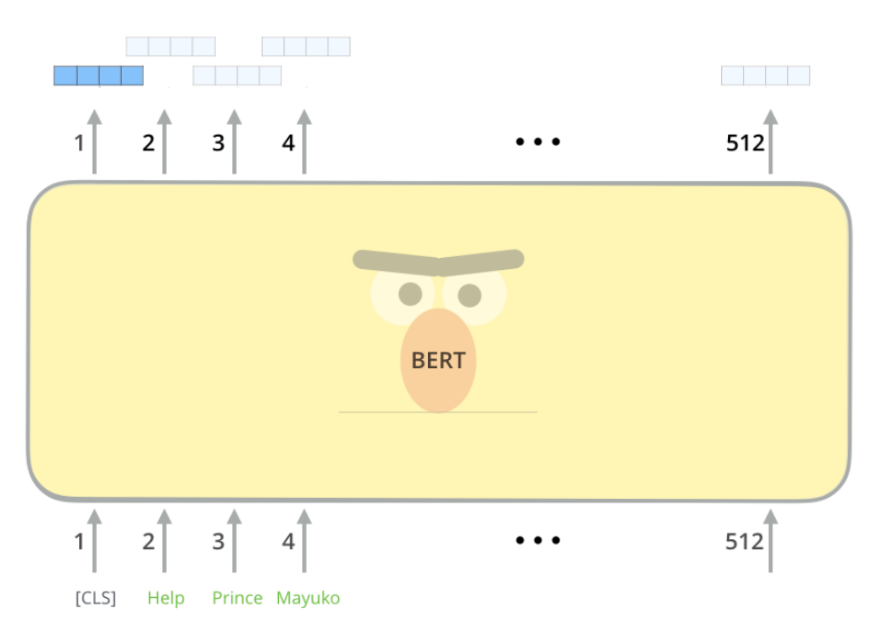

In [ ]:
# lets first get a single sentence as an example
sent_position = 7
sent = df.loc[sent_position, "sentences"]
print(sent + "\n")

# tokenize
sent_encoded = tokenizer(sent,  max_length=60, padding="max_length", truncation=True, return_tensors='pt')
sent_encoded["input_ids"]

JPMorgan Chase has experienced an extended period of significant change in laws and regulations affecting the financial services industry, both within and outside the U.S.



tensor([[  101, 16545,  5302, 16998,  5252,  2038,  5281,  2019,  3668,  2558,
          1997,  3278,  2689,  1999,  4277,  1998,  7040, 12473,  1996,  3361,
          2578,  3068,  1010,  2119,  2306,  1998,  2648,  1996,  1057,  1012,
          1055,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])

In [ ]:
# apply forward pass through the model (do not accumulate gradients; we are not training)
with torch.no_grad():
    result = model(**sent_encoded)

In [ ]:
# what is "result" ?

In [ ]:
# explore output from model
print(f"Number of hidden layers: {len(result.hidden_states)}")
print(f"Shape of output of each hidden layer: {result.hidden_states[5].shape}") # batch_size, number of tokens, embedding dimension
print(f"Shape of pooler output: {result.pooler_output.shape}") # batch_size, embedding dimension

Number of hidden layers: 13
Shape of output of each hidden layer: torch.Size([1, 60, 768])
Shape of pooler output: torch.Size([1, 768])


### Creating a sequence representation

There are several ways in which the output of BERT can be used to generate an embedded representation of a sequence of text. We will show some of them below. However, following the way in which BERT was pre-trained, we will focus on the embedded representation of the ```[CLS]``` token in the last hidden layer. This representation, is the one used to fullfil the next sentence prediction task on which BERT is trained.

In [ ]:
# use the embedding of the [CLS] token as the representation of the sequence
cls_emb = result.hidden_states[-1][0][0]
print(f"Shape of [CLS] embedding: {cls_emb.shape}")

Shape of [CLS] embedding: torch.Size([768])


In [ ]:
# we can also average the embeddings of all tokens in a given hidden state (e.g. layer 11)
avg_emb = torch.mean(result.hidden_states[-2][0], dim=0)
print(f"Shape of average embedding: {avg_emb.shape}")

Shape of average embedding: torch.Size([768])


# 3. Generating features for a regression model

We will use the embedded sequence representation that we have constructed as a covariate of a prediction model. Concretely, we will estimate a multivariate logistic regression with regularization where, for each sentence $i$ in our corpus, we predict the 2-digit NAICS sector of the firm. 

### BERT features

HuggingFace provides a very convenient interface for tokenizing and passing sequences through the model with few lines of code. To do this, we will use the ```pipeline()``` class. This class allows us to choose a particular task (e.g. features-extraction, text-classification) and, with the appropriate model and tokenizer, it will generate the correct output for the task (e.g. embedded features, classification probabilitites). All the available pipelines can be explored [here](https://huggingface.co/docs/transformers/main_classes/pipelines).

In [ ]:
# generate features from text using a pipeline object
feature_extraction = pipeline(task="feature-extraction",      # define the task
                              model=model,                    # model should be appropriate for the task
                              tokenizer=tokenizer,            # selected tokenizer
                              batch_size=16,                  # batching only supported for GPUs
                              device=0,                       # -1 for CPU and 0 for GPU
                              framework="pt"                  # data type (pt = pytorch)
                              )
# verify the task we selected
feature_extraction.task

'feature-extraction'

In [ ]:
# transform dataframe into Dataset class (easier to work with pipeline)
dataset = Dataset.from_pandas(df)
dataset

Dataset({
    features: ['sentences', 'cik', 'year', 'sent_no', 'sent_id', 'naics2', 'naics2_name', 'sentence_len', 'keep_sent'],
    num_rows: 6798
})

In [ ]:
# iterate through our sequences to extract the [CLS] embedding (takes a couple of minutes)
all_cls = []
for out in tqdm(feature_extraction(KeyDataset(dataset, "sentences"),
                                   truncation=True, 
                                   max_length=60,
                                   padding=False)
                ):
    
    # extract the [CLS] embedding from all sentences
    all_cls.append(out[0][0])

  0%|          | 0/425 [00:00<?, ?it/s]

In [ ]:
# build a dataframe with the features obtained using BERT (num_docs x 768)
df_features_bert = pd.DataFrame(all_cls)
df_features_bert

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.824840,-0.004663,-0.458258,-0.664349,-0.133645,-0.039017,-0.155485,0.280789,0.480075,-0.193740,...,-0.206574,-0.292948,-0.320678,-0.539839,-0.380370,0.073052,-0.489086,-0.318437,0.619741,0.440679
1,-0.369104,0.082162,-0.140538,-0.194881,-0.238334,-0.413053,0.269552,0.327644,0.107019,-0.212886,...,0.087334,-0.093015,0.079876,-0.250233,-0.068196,0.335319,-0.247243,-0.428237,0.268112,0.604182
2,-0.433662,0.031701,-0.500533,-0.002441,0.079370,-0.057810,-0.189215,0.499592,0.035363,0.071956,...,0.286745,-0.215691,0.007741,0.119516,-0.058923,0.277407,-0.012427,-0.266562,0.184173,0.475681
3,-0.509347,0.245026,-0.325838,-0.351404,-0.158214,0.089534,-0.100731,0.706634,-0.016048,0.215428,...,0.005461,-0.109407,0.395645,0.076005,-0.056141,-0.225529,0.502456,-0.154571,0.237927,0.777849
4,-0.479953,-0.079441,-0.270499,-0.252689,-0.241998,0.164565,-0.226165,0.382813,-0.022743,0.010087,...,0.024555,-0.068406,0.289903,0.111409,0.330467,0.121697,-0.096980,0.018022,0.267534,0.495815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6793,-0.227583,-0.172389,0.536661,-0.039504,0.132648,-0.312585,0.151738,-0.140319,0.089651,-0.462485,...,0.005395,0.064725,0.243956,-0.201387,-0.012337,-0.423015,-0.123359,0.155363,0.345266,0.481403
6794,-0.073973,0.056038,-0.006543,-0.051898,-0.151528,0.068489,0.358183,0.371048,0.424025,-0.356336,...,-0.266280,-0.085258,0.053851,-0.036734,-0.158663,-0.136171,0.038036,-0.386518,0.051225,0.345359
6795,-0.397435,0.080185,0.016016,0.373276,-0.316202,0.139612,-0.013123,0.159674,0.068773,-0.583276,...,0.072732,0.022394,0.071944,0.208614,0.027416,0.244743,-0.055598,-0.597298,0.303785,0.415647
6796,-0.641719,-0.102444,-0.131075,0.406779,-0.020079,-0.033183,-0.295510,0.254862,-0.240674,-0.299448,...,0.162494,-0.244314,0.099069,0.351340,0.286502,-0.213941,0.094505,-0.015592,0.047178,-0.113655


In [ ]:
# get only the NAICS2 code for each sentence to use as the labels for our regression
labels = df[["naics2"]]

In [ ]:
print(df_features_bert.shape, labels.shape)

(6798, 768) (6798, 1)


### Word embeddings features

We will also generate an embedded representation of sequences using word embeddings from a pre-trained model. This will give us a reference point with respect to which we can assess the quality of the features generated with BERT. 


We will use word embeddings estimated with the GloVe algorithm on Wikipedia and a large news corpus. In order to generate a single representation for a whole sentence, we will average the individual word embeddings of all words from the sentence. 


In [ ]:
# download the model and return as an object ready to use (takes a couple of minutes)
# other available models can be found here: https://kavita-ganesan.com/easily-access-pre-trained-word-embeddings-with-gensim/
#w2v_model = api.load("word2vec-google-news-300")    # model is too large to load in Colab
w2v_model = api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
# explore some of the functionality of the model
w2v_model.most_similar("cat")

[('dog', 0.6816747188568115),
 ('cats', 0.6815836429595947),
 ('pet', 0.5870364904403687),
 ('dogs', 0.5407667756080627),
 ('feline', 0.48979708552360535),
 ('monkey', 0.4879434406757355),
 ('horse', 0.4732131063938141),
 ('pets', 0.46348586678504944),
 ('rabbit', 0.4608757495880127),
 ('leopard', 0.4585462808609009)]

In [ ]:
def w2v_embed(text, w2v_model):
    """ function to generate a single embedded representation of a text
        by averaging individual word embeddings
    """
    
    # lowercase all text
    lower_text = text.lower()
    # split sentence into words by spliting on white spaces
    words = lower_text.split(" ")

    # get the word2vec embedding of all words in the vocabulary
    word_embeddings = []
    for w in words:
        if w in w2v_model.index_to_key:
            word_emb = w2v_model[w]
            word_embeddings.append(word_emb)

    if word_embeddings:
        # generate a sequence embedding by averaging all embeddings
        word_embeddings = np.array(word_embeddings)
        seq_embedding = np.mean(word_embeddings, axis=0)
        return seq_embedding
    else:
        return np.nan

In [ ]:
# transform all sequences into their w2v embedded representation (takes a couple of minutes)
all_w2v = []
valid_sents = []
for sent in tqdm(df["sentences"].values):
    seq_emb = w2v_embed(sent, w2v_model)
    if type(seq_emb) == np.ndarray:
        all_w2v.append(seq_emb)
        valid_sents.append(True)
    else:
        valid_sents.append(False)

print(len(all_w2v))

  0%|          | 0/6798 [00:00<?, ?it/s]

6798


In [ ]:
# build a dataframe with the features obtained using Word2Vec
df_features_w2v = pd.DataFrame(all_w2v)
df_features_w2v

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.032227,0.026865,-0.028346,-0.132104,-0.049463,0.149346,0.043420,0.156053,0.046826,-1.747511,...,-0.087153,-0.113003,0.016537,0.054274,0.166934,0.245733,-0.079817,-0.129016,-0.030659,0.019907
1,-0.095706,0.193188,-0.016498,-0.212017,-0.073117,0.107209,-0.008054,0.090408,0.097971,-1.793021,...,-0.134389,-0.263703,0.118702,-0.025918,0.157605,0.079458,-0.091203,-0.173823,-0.087609,-0.049550
2,-0.045260,0.183034,-0.002297,-0.129991,-0.194229,0.086583,-0.003636,0.219974,0.031304,-1.657202,...,-0.113471,-0.223888,0.017991,0.017950,0.177700,0.220204,-0.059340,-0.264458,-0.110129,-0.114141
3,0.077517,0.060096,-0.083158,-0.160014,-0.056113,0.095514,0.032513,0.268923,0.053303,-1.599497,...,-0.004302,-0.252440,-0.031537,-0.025587,0.142100,0.255869,0.042290,-0.209592,0.004680,0.056203
4,-0.073049,0.000522,0.065742,-0.130519,-0.045992,-0.017848,-0.023752,0.297938,-0.037348,-1.521862,...,-0.076941,-0.237747,-0.194894,-0.000595,0.268609,0.429685,0.207672,-0.053139,-0.173288,-0.052349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6793,-0.203348,0.040914,0.139001,-0.167000,-0.168100,0.101075,-0.056294,0.076812,-0.034586,-1.110907,...,-0.083327,-0.112596,-0.076043,-0.078832,0.163924,0.418339,0.064630,-0.081936,-0.134767,-0.170189
6794,-0.116184,0.126143,-0.065551,-0.168580,-0.025757,0.100584,-0.052877,0.151812,0.039062,-1.816366,...,-0.114093,-0.246312,0.011279,-0.076545,0.099652,0.240614,-0.220670,-0.187059,-0.128286,-0.114944
6795,-0.177607,0.135831,0.021253,-0.127163,0.070258,0.050349,0.253045,0.228192,-0.016486,-1.813566,...,-0.220819,-0.221146,0.007111,0.053194,0.205121,0.290039,-0.123578,-0.164638,-0.149576,-0.246898
6796,-0.162263,0.093744,-0.030305,-0.230433,-0.089058,0.042652,-0.039274,0.131659,0.080708,-1.544417,...,-0.038346,-0.156336,-0.058877,-0.135548,0.109679,0.206848,-0.094950,-0.221343,0.001269,-0.027154


In [ ]:
# get only the labels for those sentences with w2v embeddings
labels_w2v = labels[valid_sents]
labels_w2v.reset_index(drop=True, inplace=True)
len(labels_w2v), len(df_features_w2v)

(6798, 6798)

In [ ]:
## we could also train a Word2Vec model on our own corpus
# gensim_model = Word2Vec(sentences=df.sentences,      # corpus
#                         vector_size=100,            # embedding dimension
#                         window=4,                   # words before and after to take into consideration
#                         sg=1,                       # use skip-gram
#                         negative=5,                 # number of negative examples for each positive one
#                         alpha=0.025,                # initial learning rate
#                         min_alpha=0.0001,           # minimum learning rate
#                         epochs=5,                   # number of passes through the data
#                         min_count=1,                # words that appear less than this are removed
#                         workers=1,                  # we use 1 to ensure replicability
#                         seed=92                     # for replicability
#                        )

In [ ]:
# restrict BERT features to those sentences for which 
# we have a word embedding representation
df_features_bert = df_features_bert[valid_sents]
df_features_bert.reset_index(drop=True, inplace=True)
len(labels), len(df_features_bert)

(6798, 6798)

### Estimate regressions

In [ ]:
# create list with all the indexes of available sentences
sent_idxs = list(range(0, len(labels_w2v)))
len(sent_idxs)

6798

In [ ]:
# perform a train/test split
train_idxs, test_idxs = train_test_split(sent_idxs, test_size=0.2, random_state=92)
print(f" Train sentences: {len(train_idxs)}\n", f"Test sentences: {len(test_idxs)}")

 Train sentences: 5438
 Test sentences: 1360


In [ ]:
# select idxs for training and testing

# BERT
train_bert_features = df_features_bert.loc[train_idxs]
test_bert_features = df_features_bert.loc[test_idxs]

# Word embeddings
train_w2v_features = df_features_w2v.loc[train_idxs]
test_w2v_features = df_features_w2v.loc[test_idxs]

# Labels
train_labels = labels_w2v.loc[train_idxs]
test_labels = labels_w2v.loc[test_idxs]

In [ ]:
# BERT: fit a multinomial logistic regression to predict the sector of each sentence
lr_bert = LogisticRegression(penalty="l2",
                             multi_class = "multinomial",
                             solver="lbfgs",
                             max_iter=100000)

lr_bert.fit(train_bert_features, train_labels.values.ravel())

# Word embeddings: fit a multinomial logistic regression to predict the sector of each sentence
lr_w2v = LogisticRegression(penalty="l2",
                            multi_class = "multinomial",
                            solver="lbfgs",
                            max_iter=100000)

lr_w2v.fit(train_w2v_features, train_labels.values.ravel())

LogisticRegression(max_iter=100000, multi_class='multinomial')

In [ ]:
# get in sample predictions for both models
pred_train_bert = lr_bert.predict(train_bert_features)
pred_train_w2v = lr_w2v.predict(train_w2v_features)

print(f"Random guess accuracy: {1/len(df.groupby('naics2').size())}\n")

print("===========================\nBERT results:")
train_acc_bert = accuracy_score(train_labels, pred_train_bert)
print(f"In sample accuracy: {train_acc_bert}")
train_f1_bert = f1_score(train_labels, pred_train_bert, average="micro")
print(f"In sample F1 score: {train_f1_bert}")
train_precision_bert = precision_score(train_labels, pred_train_bert, average="micro")
print(f"In sample precision score: {train_precision_bert}")
train_recall_bert = recall_score(train_labels, pred_train_bert, average="micro")
print(f"In sample recall score: {train_recall_bert}")

print("\n===========================\nWord embeddings results:")
train_acc_w2v = accuracy_score(train_labels, pred_train_w2v)
print(f"In sample accuracy: {train_acc_w2v}")
train_f1_w2v = f1_score(train_labels, pred_train_w2v, average="micro")
print(f"In sample F1 score: {train_f1_w2v}")
train_precision_w2v = precision_score(train_labels, pred_train_w2v, average="micro")
print(f"In sample precision score: {train_precision_w2v}")
train_recall_w2v = recall_score(train_labels, pred_train_w2v, average="micro")
print(f"In sample recall score: {train_recall_w2v}")

Random guess accuracy: 0.25

BERT results:
In sample accuracy: 0.7782272894446488
In sample F1 score: 0.7782272894446489
In sample precision score: 0.7782272894446488
In sample recall score: 0.7782272894446488

Word embeddings results:
In sample accuracy: 0.6456417800662008
In sample F1 score: 0.6456417800662008
In sample precision score: 0.6456417800662008
In sample recall score: 0.6456417800662008


In [ ]:
# get out-of-sample predictions for both models
pred_test_bert = lr_bert.predict(test_bert_features)
pred_test_w2v = lr_w2v.predict(test_w2v_features)

print(f"Random guess accuracy: {1/len(df.groupby('naics2').size())}\n")

print("===========================\nBERT results:")
test_acc_bert = accuracy_score(test_labels, pred_test_bert)
print(f"Test accuracy: {test_acc_bert}")
test_f1_bert = f1_score(test_labels, pred_test_bert, average="micro")
print(f"Test F1 score: {test_f1_bert}")
test_precision_bert = precision_score(test_labels, pred_test_bert, average="micro")
print(f"Test precision score: {test_precision_bert}")
test_recall_bert = recall_score(test_labels, pred_test_bert, average="micro")
print(f"Test recall score: {test_recall_bert}")

print("\n===========================\nWord embeddings results:")
test_acc_w2v = accuracy_score(test_labels, pred_test_w2v)
print(f"Test accuracy: {test_acc_w2v}")
test_f1_w2v = f1_score(test_labels, pred_test_w2v, average="micro")
print(f"Test F1 score: {test_f1_w2v}")
test_precision_w2v = precision_score(test_labels, pred_test_w2v, average="micro")
print(f"Test precision score: {test_precision_w2v}")
test_recall_w2v = recall_score(test_labels, pred_test_w2v, average="micro")
print(f"Test recall score: {test_recall_w2v}")

Random guess accuracy: 0.25

BERT results:
Test accuracy: 0.6272058823529412
Test F1 score: 0.6272058823529412
Test precision score: 0.6272058823529412
Test recall score: 0.6272058823529412

Word embeddings results:
Test accuracy: 0.6161764705882353
Test F1 score: 0.6161764705882353
Test precision score: 0.6161764705882353
Test recall score: 0.6161764705882353


In [ ]:
# compare the 2 methods on the test sample
df_compare = pd.DataFrame({"accuracy": [test_acc_w2v, test_acc_bert],
                           "model": ["word_embeddings", "BERT"]})
df_compare

,accuracy,model
0,0.616176,word_embeddings
1,0.627206,BERT


### Out-of-corpus sentence

We can now also use our estimated regression to predict the sector of any given sequence of text we migth imagine. We will demonstrate this by using BERT.

In [ ]:
# define a target sentence
outside_target = "We are worried about misinformation and fake news."

# tokenize sentence
outside_tokens = tokenizer(outside_target, return_tensors='pt')
outside_tokens = outside_tokens.to("cuda")  # required when using GPU

# apply forward pass through the model (do not accumulate gradients; we are not training)
with torch.no_grad():
    result = model(**outside_tokens, output_attentions=True)

# extract [CLS] token embedding from last layer
outside_cls_emb = result.hidden_states[-1][0][0]
outside_cls_emb = outside_cls_emb.cpu() # required when using GPU
print(f"Shape of [CLS] embedding: {outside_cls_emb.shape}")

Shape of [CLS] embedding: torch.Size([768])


In [ ]:
df.head(2)

,sentences,cik,year,sent_no,sent_id,naics2,naics2_name,sentence_len,keep_sent
0,The following discussion sets forth the materi...,19617,2019,0,19617_0,52,Finance and Insurance,18,True
1,Readers should not consider any descriptions o...,19617,2019,1,19617_1,52,Finance and Insurance,23,True


In [ ]:
# generate class prediction for out-of-corpus sentence
outside_prediction = lr_bert.predict(outside_cls_emb.numpy().reshape(1, -1))
print(f"Predicted NAICS2 code: {outside_prediction[0]}")

# transform sector code into name
prediction_name = df.loc[df["naics2"] == outside_prediction[0]]["naics2_name"].values[0]
print(f"Predicted NAICS2 sector: {prediction_name}\n--------\n")

# generate probability predictions for out-of-corpus sentence
outside_probs = lr_bert.predict_proba(outside_cls_emb.numpy().reshape(1, -1))
outside_probs

for prob, code in zip(outside_probs[0], lr_bert.classes_):
    code_name = df.loc[df["naics2"] == code]["naics2_name"].values[0]
    print(f"Predicted probability for {code_name}: {np.round(prob,3)}")

Predicted NAICS2 code: 51
Predicted NAICS2 sector: Information
--------

Predicted probability for Manufacturing: 0.003
Predicted probability for Retail Trade: 0.279
Predicted probability for Information: 0.702
Predicted probability for Finance and Insurance: 0.016


In [ ]:
# define a target sentence
outside_target = "Our production of cars is affected by the price of steel."

# tokenize sentence
outside_tokens = tokenizer(outside_target, return_tensors='pt')
outside_tokens = outside_tokens.to("cuda")  # required when using GPU

# apply forward pass through the model (do not accumulate gradients; we are not training)
with torch.no_grad():
    result = model(**outside_tokens, output_attentions=True)

# extract [CLS] token embedding from last layer
outside_cls_emb = result.hidden_states[-1][0][0]
outside_cls_emb = outside_cls_emb.cpu() # required when using GPU

# generate class prediction for out-of-corpus sentence
outside_prediction = lr_bert.predict(outside_cls_emb.numpy().reshape(1, -1))
print(f"Predicted NAICS2 code: {outside_prediction[0]}")

# transform sector code into name
prediction_name = df.loc[df["naics2"] == outside_prediction[0]]["naics2_name"].values[0]
print(f"Predicted NAICS2 sector: {prediction_name}\n--------\n")

# generate probability predictions for out-of-corpus sentence
outside_probs = lr_bert.predict_proba(outside_cls_emb.numpy().reshape(1, -1))
outside_probs

for prob, code in zip(outside_probs[0], lr_bert.classes_):
    code_name = df.loc[df["naics2"] == code]["naics2_name"].values[0]
    print(f"Predicted probability for {code_name}: {np.round(prob,3)}")

Predicted NAICS2 code: 33
Predicted NAICS2 sector: Manufacturing
--------

Predicted probability for Manufacturing: 0.955
Predicted probability for Retail Trade: 0.039
Predicted probability for Information: 0.005
Predicted probability for Finance and Insurance: 0.0


In [ ]:
# define a target sentence
outside_target = "The decisions from the federal reserve board can affect us greatly."

# tokenize sentence
outside_tokens = tokenizer(outside_target, return_tensors='pt')
outside_tokens = outside_tokens.to("cuda")  # required when using GPU

# apply forward pass through the model (do not accumulate gradients; we are not training)
with torch.no_grad():
    result = model(**outside_tokens, output_attentions=True)

# extract [CLS] token embedding from last layer
outside_cls_emb = result.hidden_states[-1][0][0]
outside_cls_emb = outside_cls_emb.cpu() # required when using GPU

# generate class prediction for out-of-corpus sentence
outside_prediction = lr_bert.predict(outside_cls_emb.numpy().reshape(1, -1))
print(f"Predicted NAICS2 code: {outside_prediction[0]}")

# transform sector code into name
prediction_name = df.loc[df["naics2"] == outside_prediction[0]]["naics2_name"].values[0]
print(f"Predicted NAICS2 sector: {prediction_name}\n--------\n")

# generate probability predictions for out-of-corpus sentence
outside_probs = lr_bert.predict_proba(outside_cls_emb.numpy().reshape(1, -1))
outside_probs

for prob, code in zip(outside_probs[0], lr_bert.classes_):
    code_name = df.loc[df["naics2"] == code]["naics2_name"].values[0]
    print(f"Predicted probability for {code_name}: {np.round(prob,3)}")

Predicted NAICS2 code: 52
Predicted NAICS2 sector: Finance and Insurance
--------

Predicted probability for Manufacturing: 0.004
Predicted probability for Retail Trade: 0.001
Predicted probability for Information: 0.001
Predicted probability for Finance and Insurance: 0.994


# 4. Domain-specific models

So far, we have used the base version of BERT to generate features. However, one concern with this approach is that the language in the training data used for base BERT (i.e. Wikipedia and Books) migth be very different from the language in 10-K reports. In order to alleviate this concern, we will use a different version of the model trained on 260,773 10-K filings from 1993-2019.

These family of models are called [SEC-BERT](https://huggingface.co/nlpaueb/sec-bert-base) and were developed by the Natural Language Processing Group at the Athens University of Economics and Business.

> Remember that you can use [HuggingFace's ModelHub](https://huggingface.co/models) to explore more models trained on different corpora.

In [ ]:
# load a tokenizer using the name of the model we want to use
sec_tokenizer = AutoTokenizer.from_pretrained("nlpaueb/sec-bert-base")
# inspect the configuration of the tokenizer
sec_tokenizer

BertTokenizerFast(name_or_path='nlpaueb/sec-bert-base', vocab_size=30000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [ ]:
# load the model trained on 10-K report using its name
sec_model = AutoModel.from_pretrained("nlpaueb/sec-bert-base")

# put model in evaluation model (we will not do any training)
sec_model = sec_model.eval()

Some weights of the model checkpoint at nlpaueb/sec-bert-base were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# we will use the pipeline object again (but with the new model and tokenizer)
sec_feature_extraction = pipeline(task="feature-extraction",          # define the task
                                  model=sec_model,                    # model should be appropriate for the task
                                  tokenizer=sec_tokenizer,            # selected tokenizer
                                  batch_size=16,                      # batching only supported for GPUs
                                  device=0,                           # -1 for CPU and 0 for GPU
                                  framework="pt"                      # data type 
                                 )
sec_feature_extraction.task

'feature-extraction'

In [ ]:
# iterate through our sequences to extract the [CLS] embedding
all_cls_sec = []
for out in tqdm(sec_feature_extraction(KeyDataset(dataset, "sentences"),
                                       truncation=True, 
                                       max_length=60,
                                       padding=False)):
    
    # extract the [CLS] embedding from all sentences
    all_cls_sec.append(out[0][0])

  0%|          | 0/425 [00:00<?, ?it/s]

In [ ]:
# build a dataframe with the features obtained using SEC BERT
df_features_sec = pd.DataFrame(all_cls_sec)
df_features_sec = df_features_sec[valid_sents]
df_features_sec.reset_index(drop=True, inplace=True)
df_features_sec

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.376939,-0.140579,-0.428750,0.295816,0.271135,-0.164485,0.030321,-0.265742,0.385736,0.260340,...,0.003370,0.311562,0.087359,-0.083941,0.553147,-0.227895,0.388406,-0.601552,-0.316129,-0.123313
1,0.533621,0.050102,-0.311264,0.495807,-0.068415,-0.264094,-0.088141,-0.010286,0.499246,0.296850,...,-0.532170,0.676394,0.216193,-0.342861,0.676646,-0.031884,0.256060,-0.351446,-0.312332,0.000427
2,0.408385,0.025169,-0.312310,0.154127,0.127272,-0.208127,-0.052731,-0.392785,0.280328,0.131218,...,-0.449754,0.467374,0.133386,0.088486,0.388908,0.141990,0.312776,-0.499311,-0.306895,0.205140
3,0.254688,0.179559,-0.061918,-0.161153,0.315859,0.179094,0.210361,-0.021678,-0.120718,0.121269,...,-0.608426,-0.188357,0.292631,-0.129270,0.717630,-0.479501,0.290856,-0.702828,-0.505195,0.168606
4,-0.389278,-0.208216,0.183656,0.204948,0.430644,-0.412392,0.351476,-0.038184,0.205474,0.198621,...,-0.167565,0.059471,0.255661,0.400105,0.800134,-0.030727,0.019158,-0.011548,-0.055255,0.042605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6793,0.112713,0.065506,0.354329,0.322967,0.433434,0.116434,-0.329728,-0.267638,-0.343811,0.358039,...,-0.284816,0.245086,-0.071226,0.264398,0.200995,-0.549518,-0.370566,0.173479,-0.359638,-0.223027
6794,0.084064,-0.047360,-0.087702,-0.107321,-0.081663,-0.226985,-0.772778,-0.170690,-0.044984,-0.238042,...,-0.243459,0.212811,0.003240,-0.217476,0.059930,-0.089975,-0.724973,-0.332189,-0.361057,0.164427
6795,0.460132,0.103867,-0.123413,-0.395757,-0.081955,-0.298237,-0.544906,-0.214941,-0.178917,0.107354,...,0.033614,0.328427,0.006385,-0.299188,-0.009478,-0.327203,-0.566449,-0.401379,-0.308110,0.142149
6796,0.635484,-0.012616,-0.035677,-0.500130,0.373538,-0.077321,-0.458544,-0.192691,-0.322040,-0.010693,...,-0.186516,-0.092872,0.085293,-0.118705,-0.031655,-0.133606,-0.254461,-0.224571,-0.427602,0.190125


In [ ]:
# split features using the previous train/test split
train_sec_features = df_features_sec.loc[train_idxs]
test_sec_features = df_features_sec.loc[test_idxs]

In [ ]:
# fit a logistic regression to predict the sector of each sentence
# (with the same parameters as before)
lr_sec = LogisticRegression(penalty="l2",
                            multi_class = "multinomial",
                            solver="lbfgs",
                            max_iter=100000)

lr_sec.fit(train_sec_features, train_labels.values.ravel())

LogisticRegression(max_iter=100000, multi_class='multinomial')

In [ ]:
# get in sample predictions
pred_train_sec = lr_sec.predict(train_sec_features)

print(f"Random guess accuracy: {1/len(df.groupby('naics2').size())}\n")

print("===========================\nIn sample SEC BERT results:")
train_acc_sec = accuracy_score(train_labels, pred_train_sec)
print(f"In sample accuracy: {train_acc_sec}")
train_f1_sec = f1_score(train_labels, pred_train_sec, average="micro")
print(f"In sample F1 score: {train_f1_sec}")
train_precision_sec = precision_score(train_labels, pred_train_sec, average="micro")
print(f"In sample precision score: {train_precision_sec}")
train_recall_sec = recall_score(train_labels, pred_train_sec, average="micro")
print(f"In sample recall score: {train_recall_sec}")

# get out-of-sample predictions
pred_test_sec = lr_sec.predict(test_sec_features)

print("===========================\nOut of sample SEC BERT results:")
test_acc_sec = accuracy_score(test_labels, pred_test_sec)
print(f"Test accuracy: {test_acc_sec}")
test_f1_sec = f1_score(test_labels, pred_test_sec, average="micro")
print(f"Test F1 score: {test_f1_sec}")
test_precision_sec = precision_score(test_labels, pred_test_sec, average="micro")
print(f"Test precision score: {test_precision_sec}")
test_recall_sec = recall_score(test_labels, pred_test_sec, average="micro")
print(f"Test recall score: {test_recall_sec}")

Random guess accuracy: 0.25

In sample SEC BERT results:
In sample accuracy: 0.8433247517469658
In sample F1 score: 0.8433247517469658
In sample precision score: 0.8433247517469658
In sample recall score: 0.8433247517469658
Out of sample SEC BERT results:
Test accuracy: 0.7080882352941177
Test F1 score: 0.7080882352941177
Test precision score: 0.7080882352941177
Test recall score: 0.7080882352941177


In [ ]:
# compare all 3 methods
df_compare = pd.DataFrame({"accuracy": [test_acc_w2v, test_acc_bert, test_acc_sec],
                           "model": ["word_embeddings", "BERT", "SEC BERT"]})
df_compare

,accuracy,model
0,0.616176,word_embeddings
1,0.627206,BERT
2,0.708088,SEC BERT


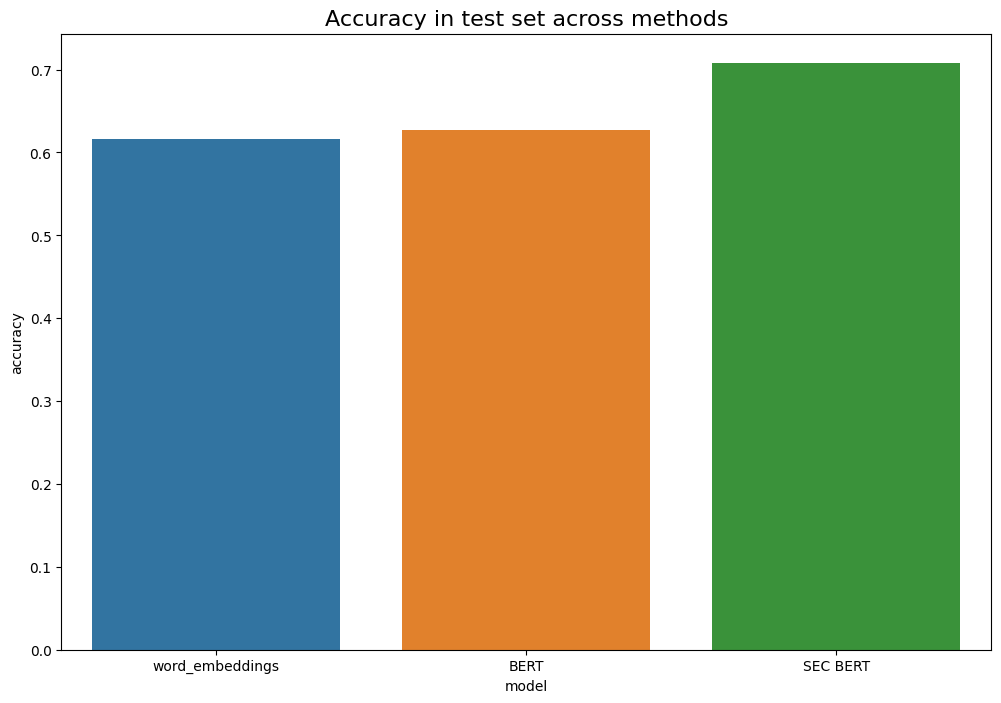

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(data=df_compare, x="model", y="accuracy")
plt.title("Accuracy in test set across methods", fontsize=16)
plt.show()